## Short form content video recommendation

In this notebook, I will be using LLaVa-NeXT-Video, a Large Vision-Language Model (LVM) that can ingest videos, to label and extract features from short-form videos, such as those on TikTok and Instagram Reels. After the feature extraction, I will employ NLP techniques to vectorize the labels(Themes in the videos) and create a queue for upcoming short videos based on cosine similarity. Essentially, I will be developing a video recommendation system that mimics user behavior on popular social media platforms like TikTok and Instagram by only considering the visual aspects of the video.

### Installing Dependencies

In [1]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.7 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-g7_d84jo
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-g7_d84jo
  Resolved https://github.com/huggingface/transformers.git to commit 080e14b24c8923e4bc18fcd54010fc7396c67bc0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.43.0.dev0-py3-none-any.whl size=9381362 sha256=354d3d40f0fe8647fa07c4ac5c1862729bb21771a69de3205b0473f910d6166b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9yp0objx/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fc

In [2]:
!pip install -q av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 48.1 MB/s eta 0:00:00


Using google drive as a server where all the videos will be stored.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the model
I will be quantising the model using bitsandbytes library and loading the model weights in 4 bit configuration as I cannot fit the full size model onto the T4 gpu which I will be using to extract themes in the videos.

In [4]:
from transformers import BitsAndBytesConfig, LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = LlavaNextVideoProcessor.from_pretrained("llava-hf/LLaVA-NeXT-Video-7B-hf")
model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    "llava-hf/LLaVA-NeXT-Video-7B-hf",
    quantization_config=quantization_config,
    device_map='auto'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


processor_config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

You are using a model of type llava_next to instantiate a model of type llava_next_video. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

### Preparing the video for the LVM

In order to read the video we'll use av and sample 16 frames. You can try to sample more frames if the video is long. The model was trained with 32 frames, but can ingest more as long as we're in the LLM backbone's max sequence length range. The videos used in this notebook were downloaded from pexels which is website where you can download photos and videos for free.

In [5]:
import av
import numpy as np

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.

    Args:
        container (av.container.input.InputContainer): PyAV container.
        indices (List[int]): List of frame indices to decode.

    Returns:
        np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [6]:
video_path_1 = '/content/drive/MyDrive/SFC_Videos/1350205-hd_1920_1080_30fps.mp4'     # Load the video from the google drive


container = av.open(video_path_1)

total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 16).astype(int)
clip = read_video_pyav(container, indices)                                            # Sample 16 frames from the video

### Testing using the first video
I will load the first video in the folder and use it to test the LVM's capabilites at feature extraction

In [7]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

video = clip

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

I realised that the sampled videos in matplotlib will not be saved when I download the .ipynb notebook, so I will be attaching a screenshot of the video wherever applicable


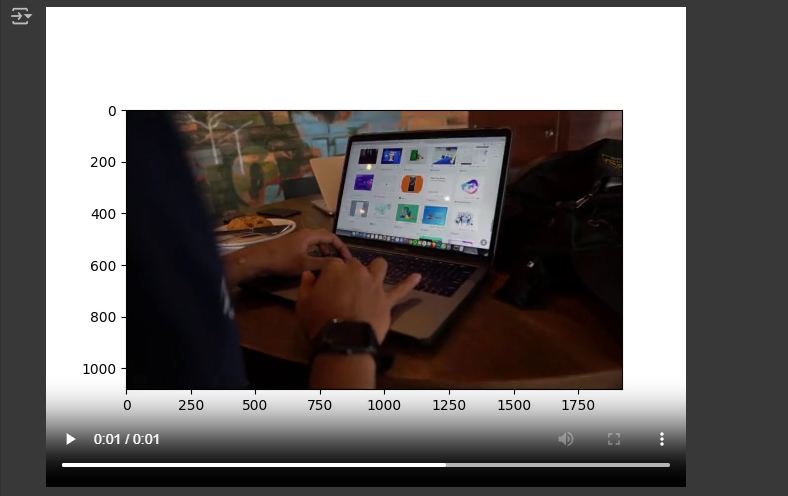

In [8]:
conversation = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": '''List only the 4 most common themes in this video. Output each theme as a single
              word or short phrase, one per line, without numbering or additional explanation.'''}, # Prompt to generate the 4 most common themes in the video
              {"type": "video"},
              ],
      },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor([prompt], videos=[clip], padding=True, return_tensors="pt").to(model.device)
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.0}              # Setting the temperature to 0 to keep the model grounded
output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


### Extracted Features

In [9]:
themes = generated_text[0].split("ASSISTANT:")[-1].strip()  # Printing the themes in the first test video we can see that the model is able to
                                                            # do a pretty good job at extracting the feautres from sampled video
print(themes)

Laptop, Hand, Food, Table


## Setting up a pipeline
Now that we know that the model is capabale of extracting features from the sampled video. Using this capability I will now build a pipeline that extracts features from short form videos and recommends a follow up video for the original video. This pipeline will take in the video path, then sample 16 frames from the video and analyse the video via the LVM to get the the 4 most common themes and adds the themes it into a structured dataframe.

This would represent the upload process for an app like tiktok.

In [10]:
def process_video(video_path, num_frames):                                # A function to sample 16 frames from the video
    container = av.open(video_path)
    total_frames = container.streams.video[0].frames
    indices = np.arange(0, total_frames, total_frames / num_frames).astype(int)
    clip = read_video_pyav(container, indices)
    return {'video_path': video_path, 'frames': clip}

In [11]:
import os

video_folder = '/content/drive/MyDrive/SFC_Videos'              # Listing all the videos that I have collected into a list
video_extensions = ('.mp4')

video_path = []

for filename in os.listdir(video_folder):
    if filename.lower().endswith(video_extensions):
        full_path = os.path.join(video_folder, filename)
        video_path.append(full_path)


In [12]:
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
                                                                              # Concurrently creating sample frames
with ThreadPoolExecutor() as executor:                                        # from all the collected videos
    results = list(executor.map(lambda x: process_video(x, 16), video_path))

videos_df = pd.DataFrame(results)                                             # Forming a dataframe with the sampled frames and the original location

A function to extract sentiment(themes) from the videos

In [13]:
def apply_sentiment_analysis(row):                        # A function that takes in row of a dataframe and
    conversation = [                                      # uses the sampled frames in the dataframe to
        {                                                 # produce the 4 most common themes in the video
            "role": "user",
            "content": [
                {"type": "text", "text": '''List only the 4 most common themes in this video. Output each theme as a single
              word or short phrase, one per line, without numbering or additional explanation.'''},
                {"type": "video"},                        # A Prompt to generate the 4 most common themes in the video
            ],
        }
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor([prompt], videos=[row['frames']], padding=True, return_tensors="pt").to(model.device)
    generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.0}  # Setting the temperature to 0 to ensure reproducibility and keep the model grounded
    output = model.generate(**inputs, **generate_kwargs)
    generated_text = processor.batch_decode(output, skip_special_tokens=True)
    return generated_text[0].split("ASSISTANT:")[-1].strip()                    # Returning only the themes

In [14]:
videos_df['generated_text'] = videos_df.apply(apply_sentiment_analysis, axis=1) # A lambda function to apply sentiment_analysis function to the entire dataset and create a new column with the themes


In [15]:
videos_df.head()

video_path  \
0  /content/drive/MyDrive/SFC_Videos/2034291-uhd_...   
1  /content/drive/MyDrive/SFC_Videos/1531069-uhd_...   
2  /content/drive/MyDrive/SFC_Videos/3009091-uhd_...   
3  /content/drive/MyDrive/SFC_Videos/3191251-uhd_...   
4  /content/drive/MyDrive/SFC_Videos/4267751-uhd_...   

                                              frames  \
0  [[[[ 48 128 179], [ 48 128 179], [ 48 128 179]...   
1  [[[[166 155 140], [167 156 141], [168 157 142]...   
2  [[[[149 133 131], [148 132 130], [148 132 130]...   
3  [[[[15 30 18], [16 31 19], [16 31 19], [16 31 ...   
4  [[[[97 92 89], [97 92 89], [97 92 89], [97 92 ...   

                                      generated_text  
0        Cityscape, Buildings, Skyline, Sunset, City  
1  Cityscape, sunset, skyline, waterfront, bridge...  
2               Cat, Outdoor, Walking, Garden, Brick  
3                       Dog, Park, Play, Treat, Hand  
4         Dogs, Hugging, Outdoors, Sunglasses, Jeans

Another NLP function to use the themes generated by the LVM to recommend the next video in the queue

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def queue_videos(current_video_id, videos_df, num_recommendations=5):           # An NLP function that takes in the dataframe along with the sentiments(themes of the videos)
    current_sentiment = videos_df.loc[videos_df['video_path'] == current_video_id, 'generated_text'].iloc[0]  # and produces a queue of 5 videos by default by computing the cosine
                                                                                      # similarities with the different themes in the dataset

    vectorizer = TfidfVectorizer()
    sentiment_matrix = vectorizer.fit_transform(videos_df['generated_text'])

    similarity_scores = cosine_similarity(sentiment_matrix[videos_df['video_path'] == current_video_id], sentiment_matrix).flatten()

    similar_indices = similarity_scores.argsort()[::-1][1:num_recommendations+1]

    recommended_videos = videos_df.iloc[similar_indices]['video_path'].tolist()

    return recommended_videos


### Testing the pipeline

Now that the dataset contains the themes extracted from all the 49 videos I collected I will be choosing a random starting video to act as the first video on the user's feed and then queue up other sequential videos for them to watch by using the queue_videos based on their current video.

But to actually play the video in the colab environment I will be creating a function by reusing the sampling code created earlier in the notebook which uses av library and matplotlib to recreate the sampled video. I want to replace this code with something that will all play the videos in their native frame rate but unfortunately the colab environment does not allow me to do that.

In [17]:
import av
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def play_video(video_path):                                                     # A function to play video from a location
    container = av.open(video_path)                                             # I have reused the code from the earlier video sampling code and have just created a function around it
                                                                                # I wanted to play the full video without sampling but google colab does not allow me to do that for some reason
    total_frames = container.streams.video[0].frames
    indices = np.arange(0, total_frames, total_frames / 16).astype(int)
    clip = read_video_pyav(container, indices)

    fig = plt.figure()
    im = plt.imshow(clip[0,:,:,:])

    plt.close()

    def init():
        im.set_data(clip[0,:,:,:])

    def animate(i):
        im.set_data(clip[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=clip.shape[0], interval=100)
    return HTML(anim.to_html5_video())




### First Random Video

Selecting a random video and generating a queue with similar videos from that random video

In [48]:
video_id_1 = '/content/drive/MyDrive/SFC_Videos/1649831-uhd_3840_2160_30fps.mp4'    # I will be using this random video I chose as a starting point
recommended_queue = queue_videos(video_id_1, videos_df)                     # I will then be passing this video to the queue_videos function that will recommend the next 5 videos
print(f"Recommended videos: {recommended_queue}")

Recommended videos: ['/content/drive/MyDrive/SFC_Videos/857137-hd_1280_720_24fps.mp4', '/content/drive/MyDrive/SFC_Videos/20139156-uhd_2160_3840_24fps.mp4', '/content/drive/MyDrive/SFC_Videos/3197604-hd_1080_1920_25fps.mp4', '/content/drive/MyDrive/SFC_Videos/856064-hd_1920_1080_30fps.mp4', '/content/drive/MyDrive/SFC_Videos/4775515-hd_1920_1080_30fps.mp4']


Playing that random video:

In [49]:
play_video(video_id_1)

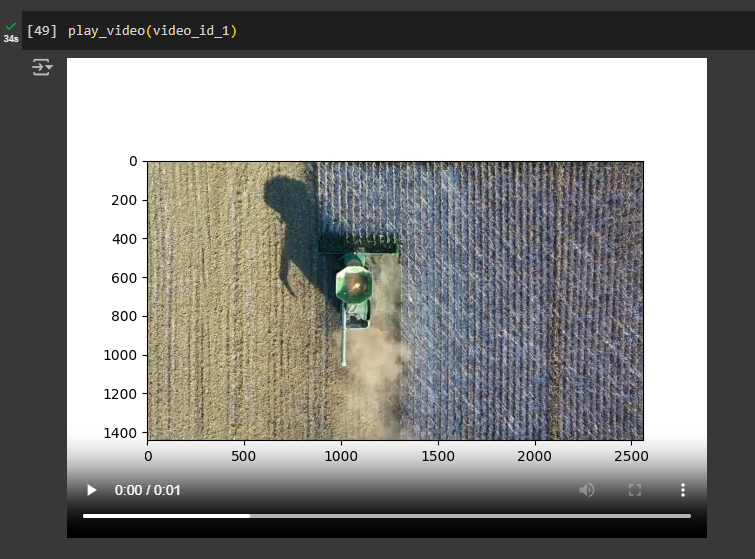

In [51]:
recommended_queue[0]

'/content/drive/MyDrive/SFC_Videos/857137-hd_1280_720_24fps.mp4'

The input video is of an tractor harvesting a field and let's see if the recommended video from this input video will be similar

Playing the the next video recommended by the NLP function:

In [50]:
play_video(f'{recommended_queue[0]}')

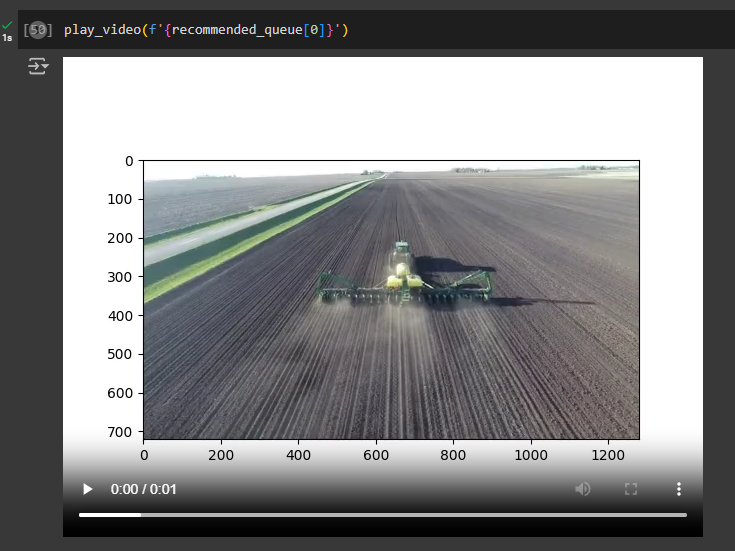

And the NLP function recommended a video of another tractor farming in field as the most similar to the input video and this makes sense because the LVM would've picked up the tractor and the farm from the original input video and there's tractor and farm in the next video.

### Second Random Video
Selecting another random video and generating a queue with similar videos from that 2nd random video

In [30]:
video_id_2 = '/content/drive/MyDrive/SFC_Videos/3196218-uhd_3840_2160_25fps.mp4'    # I will be using this random video I chose as a starting point
recommended_queue = queue_videos(video_id_2, videos_df)                     # I will then be passing this video to the queue_videos function that will recommend the next 5 videos
print(f"Recommended videos: {recommended_queue}")

Recommended videos: ['/content/drive/MyDrive/SFC_Videos/4438080-hd_1920_1080_25fps.mp4', '/content/drive/MyDrive/SFC_Videos/4761738-uhd_4096_2160_25fps.mp4', '/content/drive/MyDrive/SFC_Videos/2025457-hd_1280_720_30fps.mp4', '/content/drive/MyDrive/SFC_Videos/3197604-hd_1080_1920_25fps.mp4', '/content/drive/MyDrive/SFC_Videos/4775515-hd_1920_1080_30fps.mp4']


Playing the 2nd random video

In [31]:
play_video(video_id_2)

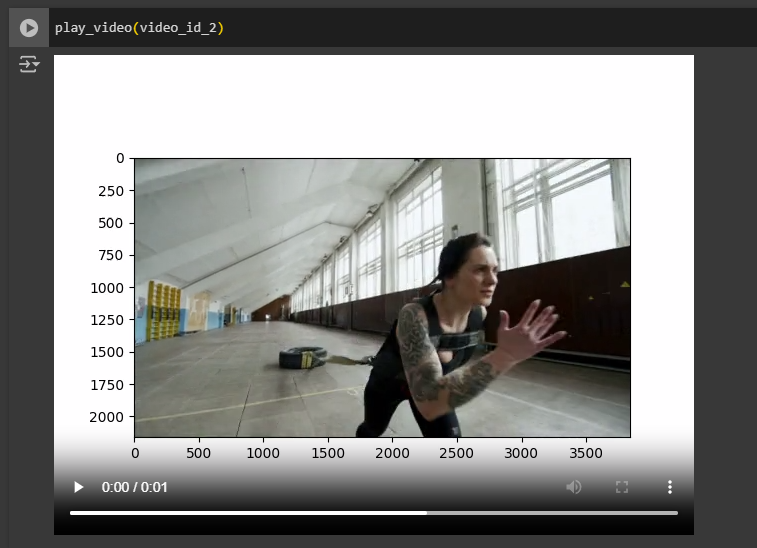

Playing the the next video recommended by the NLP function

In [32]:
play_video(f'{recommended_queue[0]}')

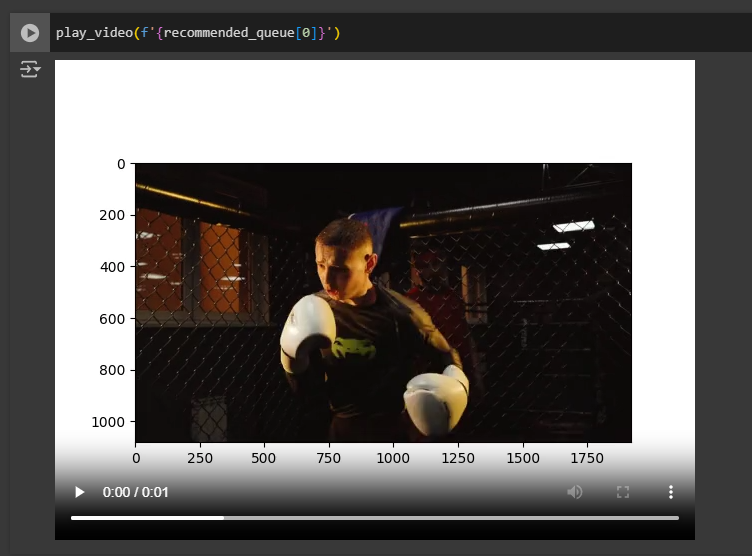

The input video this time is a woman working out and the output recommended video is of a guy boxing which is again similar is both of them are in the realm of fitness.

### Third Random Video
Selecting a 3rd random video and generating a queue with similar videos from that random video

In [33]:
video_id_3 = '/content/drive/MyDrive/SFC_Videos/854751-hd_1920_1080_25fps.mp4'    # I will be using this random video I chose as a starting point
recommended_queue = queue_videos(video_id_3, videos_df)                     # I will then be passing this video to the queue_videos function that will recommend the next 5 videos
print(f"Recommended videos: {recommended_queue}")

Recommended videos: ['/content/drive/MyDrive/SFC_Videos/4066355-uhd_3840_2160_24fps.mp4', '/content/drive/MyDrive/SFC_Videos/2025457-hd_1280_720_30fps.mp4', '/content/drive/MyDrive/SFC_Videos/4047863-hd_1920_1080_25fps.mp4', '/content/drive/MyDrive/SFC_Videos/4775515-hd_1920_1080_30fps.mp4', '/content/drive/MyDrive/SFC_Videos/856064-hd_1920_1080_30fps.mp4']


The 3rd random video

In [34]:
play_video(video_id_3)

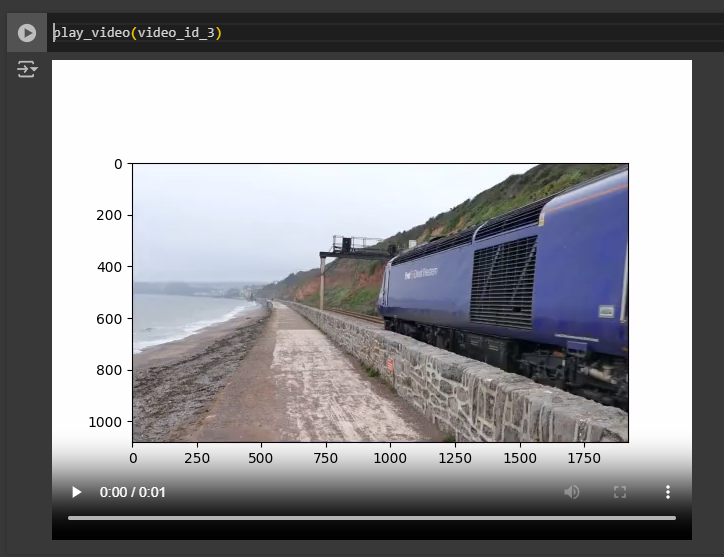

Playing the the next video recommended by the NLP function

In [35]:
play_video(f'{recommended_queue[0]}')

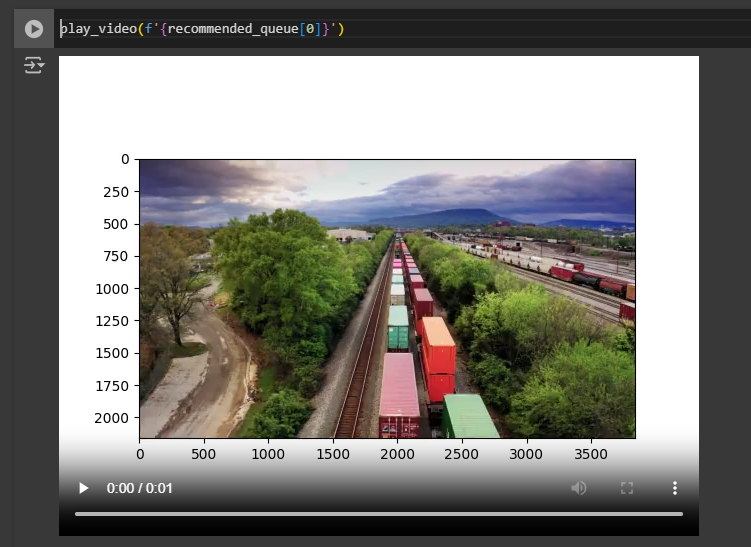

The 3rd input video is of a train going past and the recommended video is of another train being filmed going past from the POV of a drone which is again similar.

## Conclusion and future work
From these 3 examples it is clear that the recommendation pipeline is working well and the LVM is able to understand the videos and summarise them really well.


Future Work:



*   Include Audio:Audio is a big part of TikTok and Instagram Reels and other short form content websites and the current pipeline does not account for the audio in these videos. Including audio within this particular recommendation system can also be done but I'm not sure where I would get the data to demonstrate that pipeline as I don't want anything to do with copyright
*   Inlcude User History and Behaviour: The current pipeline does not account for the user history like the previous videos watched or their behaviour like their interaction with the videos i.e, whether they liked/commented on the video. Considering this will very usefull in making recommendations to the user.
